In [1]:
import numpy as np
import sklearn
import pandas as pd
from PIL import Image
import os
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.measure import block_reduce
from sklearn.cluster import MeanShift

In [2]:
data = {'gt':[], 'nt':[], 'mt':[], 'pt':[]}

def im_to_arr(dfl:list, path:str):
    filenames = os.listdir(path=path)
    filen = len(filenames)
    for i in range(filen):
        img = Image.open(path+'/'+filenames[i]).convert('L')
        dfl.append([np.asarray(img), img])

In [3]:
im_to_arr(data['gt'], "tumor_dataset/Training/glioma_tumor")
im_to_arr(data['nt'], "tumor_dataset/Training/no_tumor")
im_to_arr(data['mt'], "tumor_dataset/Training/meningioma_tumor")
im_to_arr(data['pt'], "tumor_dataset/Training/pituitary_tumor")

In [4]:
def imageshow(arr:np.ndarray):
    plt.figure(figsize=(5, 5))
    plt.imshow(arr, cmap='gray')
    plt.axis('off')
    plt.show()

In [5]:
def imgshow5x5(l:list, order=False) -> list:
    imgtable = [l[i] for i in np.random.choice(list(range(len(l))), size=25, replace=False)] \
        if not order else [l[i] for i in order]
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))

    for i in range(5):
        for j in range(5):
            axes[i, j].imshow(imgtable[i*5+j], cmap='gray')
            axes[i, j].axis('off')
            
    plt.show()
    return imgtable

이미지 비율이 512x512가 아닌 애들끼리 학습(512*512 & no_tumor인건 제거)   
이미지 비율이 512x512인 애들은 사진 찍은 각도에 대해 분류 후 지들끼리 하거나 레이블 추가

In [6]:
def delete_bg(imgarr:np.ndarray, img:Image) -> list:
    ''' return `True` if img is 512x512 for third value. '''
    margin = [[-1,-1],[-1,-1]]
    wh = img.size
    for i in range(2):
        max_col = imgarr.max(axis=i)
        arr = max_col >= 40; streak = [0,0]; ssp = [-1,-1]; flag = 0
        for j in range(wh[i]):
            if flag == 2: break
            if margin[i][0] == -1:
                if arr[j]:
                    streak[0] += 1
                    if ssp[0] == -1: ssp[0] = j
                    if streak[0] >= wh[i]//7:
                        margin[i][0] = ssp[0]; flag += 1
                else: streak[0] = 0; ssp[0] = -1
            if margin[i][1] == -1:
                if arr[-j-1]:
                    streak[1] += 1
                    if ssp[1] == -1: ssp[1] = wh[i]-j
                    if streak[1] >= wh[i]//7:
                        margin[i][1] = ssp[1]; flag += 1
                else: streak[1] = 0; ssp[1] = -1
        # margin[i][0] = np.argmax(max_col >= 40); margin[i][1] = wh[i] - np.argmax(np.flip(max_col) >= 40)
    timg = img.crop((margin[0][0],margin[1][0],margin[0][1],margin[1][1])).resize((512,512))
    timgarr = np.asarray(timg)
    
    return [timgarr, timg, wh[0] == 512 and wh[1] == 512]

In [7]:
for k in data.keys():
    for i in range(len(data[k])):
        data[k][i] = delete_bg(data[k][i][0], data[k][i][1])

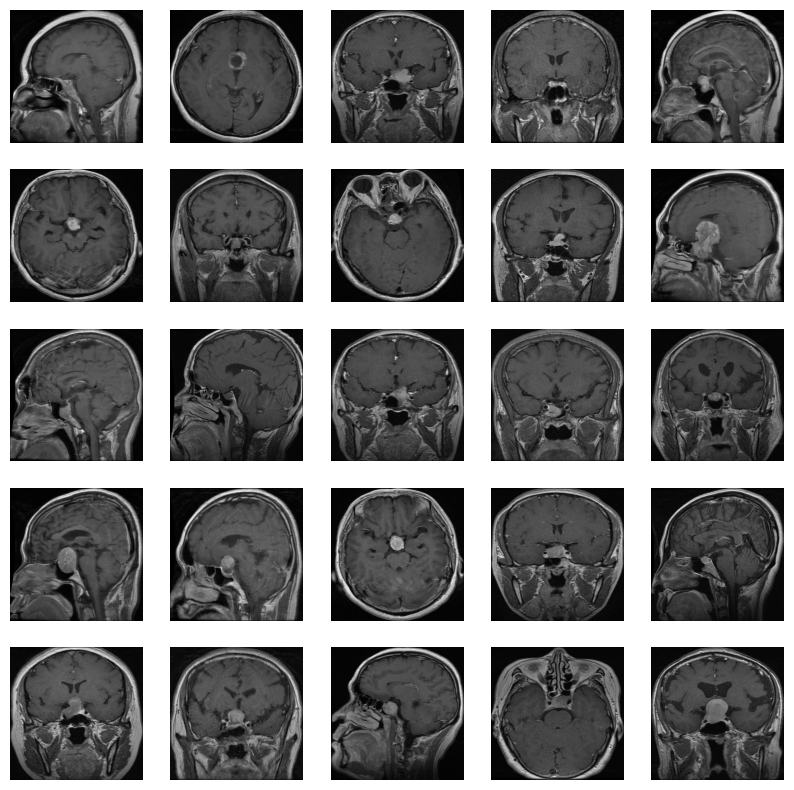

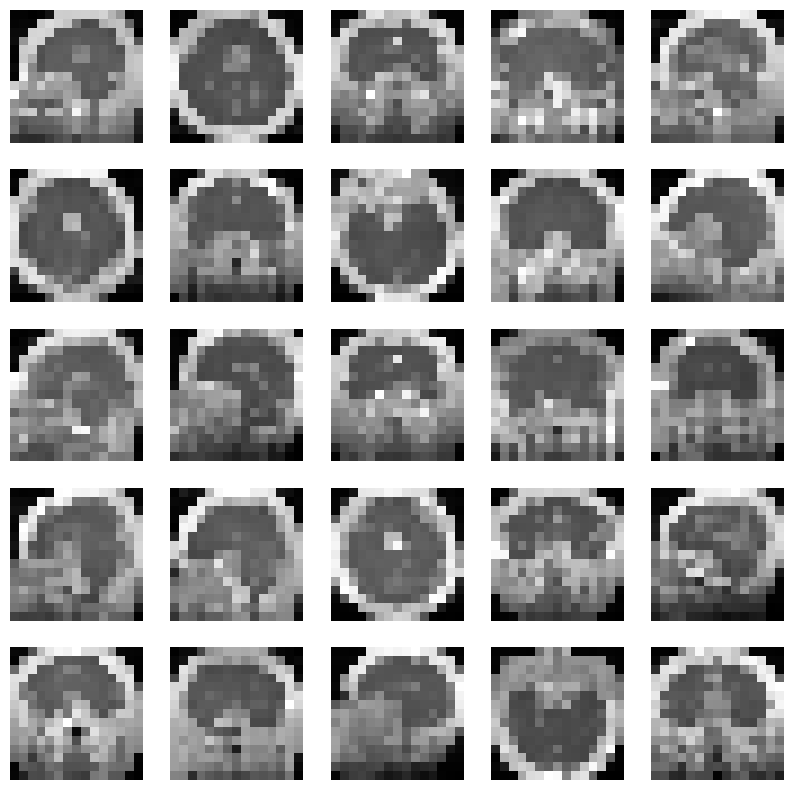

In [16]:
imgtable = imgshow5x5(list(map(lambda x: x[0], data['pt'])))
pooled = [block_reduce(np.asarray(imgtable[i]), (35, 35), np.max) for i in range(25)]
_ = imgshow5x5(pooled, order=list(range(25)))

In [11]:
pooled = []
for k in data.keys():
    data_len = len(data[k])
    pooled += [block_reduce(data[k][i][0], (15, 15), np.max) for i in range(data_len)]

pooled = [arr.reshape(arr.shape[0]*arr.shape[1]) for arr in pooled]
pooled[0].shape


[array([3, 3, 3, ..., 2, 2, 2], dtype=uint8),
 array([7, 7, 7, ..., 4, 4, 4], dtype=uint8),
 array([5, 6, 6, ..., 6, 2, 2], dtype=uint8),
 array([4, 4, 4, ..., 5, 1, 1], dtype=uint8),
 array([ 4,  3,  3, ..., 10,  1,  1], dtype=uint8),
 array([5, 4, 6, ..., 1, 1, 1], dtype=uint8),
 array([4, 5, 4, ..., 1, 1, 1], dtype=uint8),
 array([5, 5, 6, ..., 4, 2, 1], dtype=uint8),
 array([4, 5, 5, ..., 4, 3, 2], dtype=uint8),
 array([3, 5, 6, ..., 8, 2, 1], dtype=uint8),
 array([7, 6, 8, ..., 2, 2, 2], dtype=uint8),
 array([6, 4, 4, ..., 1, 2, 1], dtype=uint8),
 array([4, 4, 3, ..., 3, 3, 3], dtype=uint8),
 array([7, 5, 5, ..., 2, 2, 2], dtype=uint8),
 array([4, 5, 5, ..., 2, 1, 1], dtype=uint8),
 array([5, 5, 6, ..., 2, 2, 1], dtype=uint8),
 array([4, 4, 6, ..., 3, 1, 1], dtype=uint8),
 array([4, 4, 5, ..., 3, 2, 2], dtype=uint8),
 array([5, 4, 6, ..., 3, 3, 1], dtype=uint8),
 array([3, 3, 4, ..., 7, 2, 2], dtype=uint8),
 array([5, 4, 3, ..., 2, 1, 1], dtype=uint8),
 array([ 3,  4,  4, ..., 18,

In [13]:
angle_df = pd.DataFrame(pooled)
angle_df

,0,1,2,3,4,5,6,7,8,9,...,1215,1216,1217,1218,1219,1220,1221,1222,1223,1224
0,3,3,3,3,3,3,3,4,5,6,...,2,2,2,2,2,2,2,2,2,2
1,7,7,7,10,7,9,8,9,9,75,...,3,3,3,4,3,4,4,4,4,4
2,5,6,6,5,5,6,5,5,4,5,...,39,26,13,11,13,14,9,6,2,2
3,4,4,4,3,3,4,4,5,3,4,...,29,34,30,22,41,43,31,5,1,1
4,4,3,3,4,6,3,3,3,3,3,...,40,36,44,33,34,46,36,10,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2865,8,8,9,9,10,9,7,11,10,9,...,60,65,56,9,6,5,5,5,4,2
2866,10,8,9,9,8,8,9,10,9,11,...,53,48,40,3,4,3,2,2,2,1
2867,8,10,10,9,8,9,9,8,8,9,...,50,57,49,9,6,6,4,3,3,2
2868,10,10,12,10,11,11,10,10,10,12,...,59,49,26,20,19,23,38,35,6,2


In [14]:
ms = MeanShift()
ms.fit(angle_df)
ms.labels_

KeyboardInterrupt: 